In [4]:
# Libraries for R^2 visualization
from ipywidgets import interactive, IntSlider, FloatSlider
from math import floor, ceil
from sklearn.base import BaseEstimator, RegressorMixin

# Libraries for model building
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Library for working locally or Colab
import sys

In [5]:
# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'

# I. Wrangle Data

In [20]:
col_names = ['year', 'incumbent', 'challenger', 'income', 'fatalities', 'incumbent_vote_share']
df = pd.read_csv(DATA_PATH + 'elections/bread_peace_voting.csv',
#                 parse_dates=['year'],
                 names=col_names,
                 header=0,
                index_col='year')
# df.columns = ['incumbent', 'challenger', 'income', 'fatalities', 'incumbent_vote_share']
print(df.shape)
print(df.info())
df

(17, 5)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 17 entries, 1952 to 2016
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   incumbent             17 non-null     object 
 1   challenger            17 non-null     object 
 2   income                17 non-null     float64
 3   fatalities            17 non-null     int64  
 4   incumbent_vote_share  17 non-null     float64
dtypes: float64(2), int64(1), object(2)
memory usage: 816.0+ bytes
None


,incumbent,challenger,income,fatalities,incumbent_vote_share
year,,,,,
1952,Stevenson,Eisenhower,2.40,190,44.60
1956,Eisenhower,Stevenson,2.89,0,57.76
1960,Nixon,Kennedy,0.85,0,49.91
1964,Johnson,Goldwater,4.21,1,61.34
1968,Humphrey,Nixon,3.02,146,49.60
1972,Nixon,McGovern,3.62,0,61.79
1976,Ford,Carter,1.08,2,48.95
1980,Carter,Reagan,-0.39,0,44.70
1984,Reagan,Mondale,3.86,0,59.17


Text(0, 0.5, 'Incumbent Party Vote Shae [%]')

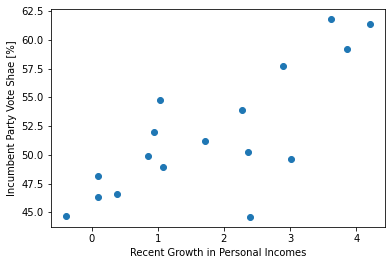

In [24]:
plt.scatter(df['income'],df['incumbent_vote_share'])
plt.xlabel('Recent Growth in Personal Incomes')
plt.ylabel('Incumbent Party Vote Shae [%]')

Text(0, 0.5, 'Incumbent Party Vote Shae [%]')

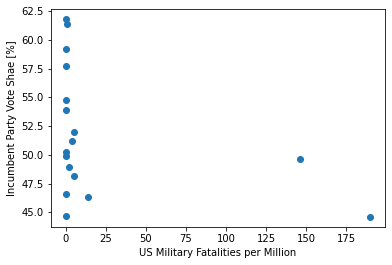

In [23]:
plt.scatter(df['fatalities'],df['incumbent_vote_share'])
plt.xlabel('US Military Fatalities per Million')
plt.ylabel('Incumbent Party Vote Shae [%]')

# II. Split Data

**First** we need to split our **target vector** from our **feature matrix**.

In [55]:
y = df['incumbent_vote_share'] # is one-dimensional
X = df[['income', 'fatalities']] # is two-dimensional
X.head()

,income,fatalities
year,,
1952,2.40,190
1956,2.89,0
1960,0.85,0
1964,4.21,1
1968,3.02,146


**Second** we need to split our dataset into **training** and **test** sets.

Two strategies:

- Random train-test split using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Generally we use 80% of the data for training, and 20% of the data for testing.
- If you have **timeseries**, then you need to do a "cutoff" split.

In [56]:
# train on data before 2008 and test on data from 2008 - present

# method 1
cutoff = 2008
mask = X.index < 2008
X_train = X.loc[mask]
X_train, y_train = X.loc[mask], y.loc[mask]
X_test, y_test = X.loc[~mask], y.loc[~mask]

In [57]:
# method 2
cutoff = int(len(X) * 0.8)
X_train, y_train = X.iloc[:cutoff], y.iloc[:cutoff]
X_test, y_test = X.iloc[cutoff:], y.iloc[cutoff:]

# III. Establish Baseline

In [58]:
y_pred = [y_train.mean()] * len(y_train) # use training data
print('Mean Incumbent Vote Share:', y_train.mean())
print('Baseline MAE:', mean_absolute_error(y_train,y_pred))

Mean Incumbent Vote Share: 52.56307692307692
Baseline MAE: 5.132544378698224


# IV. Build Model

In [59]:
# step 1: import your predictor class
# step 2: instantiate your model (class -> object)
model = LinearRegression()
# step 3: fit your training data to the model
model.fit(X_train, y_train);

# V. Check Metrics

## Mean Absolute Error

The unit of measurement is the same as the unit of measurment for your target (in this case, vote share [%]).

In [60]:
print('Training MAE:', mean_absolute_error(y_train,model.predict(X_train)))
print('Test MAE:', mean_absolute_error(y_test,model.predict(X_test)))

Training MAE: 1.3737002516876717
Test MAE: 1.4133453705003944


## Root Mean Squared Error

The unit of measurement is the same as the unit of measurment for your target (in this case, vote share [%]).

In [61]:
print('Training RMSE:', mean_squared_error(y_train,model.predict(X_train),squared=False))
print('Test RMSE:', mean_squared_error(y_test,model.predict(X_test),squared=False))

Training RMSE: 2.0376005753896838
Test RMSE: 1.623765003537601


## $R^2$ Score

TL;DR: Usually ranges between 0 (bad) and 1 (good).

In [46]:
class BruteForceRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, m=0, b=0):
        self.m = m
        self.b = b
        self.mean = 0
        
    def fit(self, X, y):
        self.mean = np.mean(y)
        return self
    
    def predict(self, X, return_mean=True):
        if return_mean:
            return [self.mean] * len(X)
        else:
            return X * self.m + self.b

def plot(slope, intercept):
    # Assign data to variables
    x = df['income']
    y = df['incumbent_vote_share']
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,6))
    
    # Set ax limits
    mar = 0.2
    x_lim = floor(x.min() - x.min()*mar), ceil(x.max() + x.min()*mar)
    y_lim = floor(y.min() - y.min()*mar), ceil(y.max() + y.min()*mar)
    
    # Instantiate and train model
    bfr = BruteForceRegressor(slope, intercept)
    bfr.fit(x, y)
    
    # ax1   
    ## Plot data
    ax1.set_xlim(x_lim)
    ax1.set_ylim(y_lim)
    ax1.scatter(x, y)
    
    ## Plot base model
    ax1.axhline(bfr.mean, color='orange', label='baseline model')
    
    ## Plot residual lines
    y_base_pred = bfr.predict(x)
    ss_base = mean_squared_error(y, y_base_pred) * len(y)
    for x_i, y_i, yp_i in zip(x, y, y_base_pred):
        ax1.plot([x_i, x_i], [y_i, yp_i], 
                 color='gray', linestyle='--', alpha=0.75)
    
    ## Formatting
    ax1.legend()
    ax1.set_title(f'Sum of Squares: {np.round(ss_base, 2)}')
    ax1.set_xlabel('Growth in Personal Incomes')
    ax1.set_ylabel('Incumbent Party Vote Share [%]')

    # ax2

    ax2.set_xlim(x_lim)
    ax2.set_ylim(y_lim)
    ## Plot data
    ax2.scatter(x, y)
    
    ## Plot model
    x_model = np.linspace(*ax2.get_xlim(), 10)
    y_model = bfr.predict(x_model, return_mean=False)
    ax2.plot(x_model, y_model, color='green', label='our model')
    for x_coord, y_coord in zip(x, y):
        ax2.plot([x_coord, x_coord], [y_coord, x_coord * slope + intercept], 
                 color='gray', linestyle='--', alpha=0.75)   
    
    ss_ours = mean_squared_error(y, bfr.predict(x, return_mean=False)) * len(y)
    
    ## Formatting
    ax2.legend()
    ax2.set_title(f'Sum of Squares: {np.round(ss_ours, 2)}')
    ax2.set_xlabel('Growth in Personal Incomes')
    ax2.set_ylabel('Incumbent Party Vote Share [%]')

y = df['incumbent_vote_share']
slope_slider = FloatSlider(min=-5, max=5, step=0.5, value=0)
intercept_slider = FloatSlider(min=int(y.min()), max=y.max(), step=2, value=y.mean())
    
interactive(plot, slope=slope_slider, intercept=intercept_slider)

interactive(children=(FloatSlider(value=0.0, description='slope', max=5.0, min=-5.0, step=0.5), FloatSlider(va…

In [62]:
print('Training R^2:', r2_score(y_train,model.predict(X_train)))
print('Test R^2:', r2_score(y_test,model.predict(X_test)))

Training R^2: 0.8759203630180873
Test R^2: 0.4993519697110995


In [52]:
# if regression problem, alternative method
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))

0.5647747542705919
0.32493052339718853


# VI. Communicate Results

**Challenge:** How can we find the coefficients and intercept for our `model`?